# Custom-Built Model for Yoga Pose Identification:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow import keras

from math import sin
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import F1Score, Precision, Recall
from keras.regularizers import l1, l2, l1_l2

import os
from PIL import Image

# Data Import, EDA, and Dataset Creation:

In [ ]:
# Import Dataset Directly from Kaggle:
#!pip install kaggle
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

#!kaggle datasets download -d arrowe/yoga-poses-dataset-107
#!unzip /content/yoga-poses-dataset-107.zip


Streaming output truncated to the last 5000 lines.
  inflating: 107 yoga poses/train/ardha matsyendrasana/39-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/40-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/44-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/46-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/46-1.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/47-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/49-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/50-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/51-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/52-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/53-0.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/53-1.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/53-2.png  
  inflating: 107 yoga poses/train/ardha matsyendrasana/54-0.png  
  inflating: 107 yoga pos

In [ ]:
# Capture basic information about each image, including the image dimensions, which subset it is from, and which pose it represents:
directories = ["/content/107 yoga poses/test", "/content/107 yoga poses/train", "/content/107 yoga poses/val"]

widths = []
heights = []
dataset = []
pose = []

for image_dir in directories:
  for sub_folder in os.listdir(image_dir):
    # Get the path of each sub-folder
    sub_folder_path = os.path.join(image_dir, sub_folder)

    # Iterate through each image in the sub-folder
    for image_name in os.listdir(sub_folder_path):
      # Open the image
      image_path = os.path.join(sub_folder_path, image_name)
      image = Image.open(image_path)

      # Get the image dimensions and store
      width, height = image.size
      widths.append(width)
      heights.append(height)
      dataset.append(image_dir.removeprefix("/content/107 yoga poses/"))
      pose.append(sub_folder)

df_metadata = pd.DataFrame({"Width": widths, "Height": heights, "Dataset": dataset, "Pose": pose})

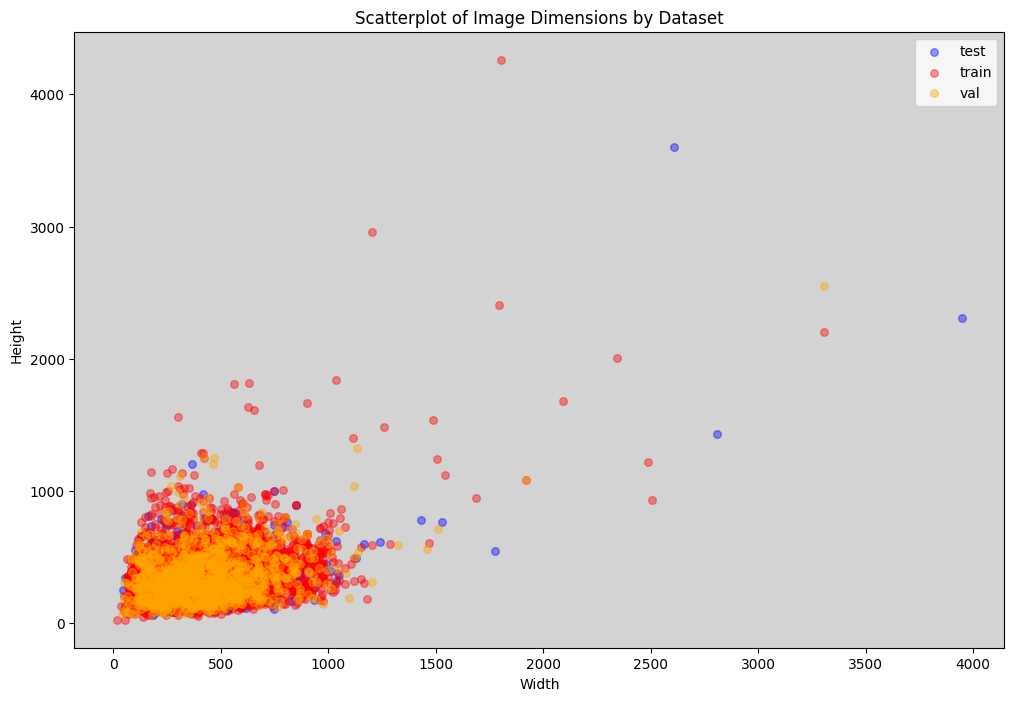

In [ ]:
plt.figure(figsize=(12, 8))

# Map dataset names to distinct colors
dataset_mapping = {"test": "blue",
                   "train": "red",
                   "val": "orange"}
df_metadata["Dataset_Color"] = df_metadata["Dataset"].map(dataset_mapping)

# Scatter plot with mapped colors
for dataset, color in dataset_mapping.items():
    subset = df_metadata[df_metadata["Dataset"] == dataset]
    plt.scatter(subset["Width"], subset["Height"], c=color, label=dataset.split('/')[-1], s = 30, alpha = 0.4)

plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Scatterplot of Image Dimensions by Dataset")
plt.gca().set_facecolor('lightgrey')
plt.legend()
plt.show()

In [ ]:
# Evaluate the Data Imbalance Across Classes:
df_pose_counts = pd.crosstab(df_metadata['Pose'], df_metadata['Dataset'])
df_pose_counts.sort_values(by=['train'], inplace=True)
print(df_pose_counts)

Dataset               test  train  val
Pose                                  
padangusthasana          3     12    3
tulasana                 4     21    6
agnistambhasana          4     23    6
marichyasana iii         4     23    6
ashtanga namaskara       5     23    6
...                    ...    ...  ...
garudasana               9     54   15
ustrasana               10     60   17
bitilasana              10     60   17
ardha matsyendrasana    10     62   18
chaturanga dandasana    10     62   18

[107 rows x 3 columns]


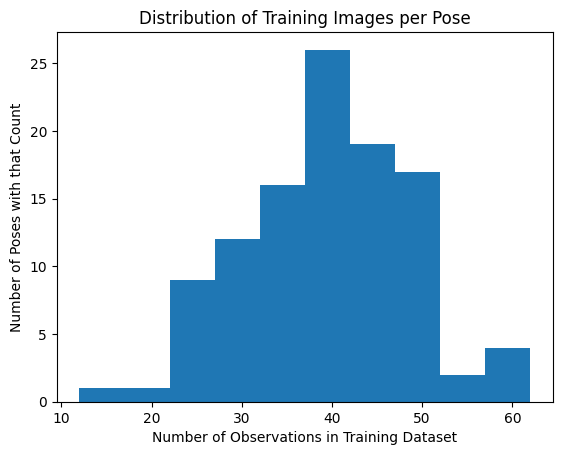

In [ ]:
# Plot Distribution of Poses in Training Dataset:
plt.hist(df_pose_counts['train'])
plt.xlabel('Number of Observations in Training Dataset')
plt.ylabel('Number of Poses with that Count')
plt.title('Distribution of Training Images per Pose')
plt.show()


In [ ]:
# Load Train, Validate, and Test Datasets as tf.data.Dataset objects:
(train) = keras.utils.image_dataset_from_directory(
    "/content/107 yoga poses/train",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=47,
    interpolation="bilinear",
    #follow_links=False,
    #pad_to_aspect_ratio=True
)

(val) = keras.utils.image_dataset_from_directory(
    "/content/107 yoga poses/val",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=47,
    interpolation="bilinear",
    #follow_links=False,
    #pad_to_aspect_ratio=True
)

(test) = keras.utils.image_dataset_from_directory(
    "/content/107 yoga poses/test",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=47,
    interpolation="bilinear",
    follow_links=False,
    #pad_to_aspect_ratio=True
)

Found 4149 files belonging to 107 classes.
Found 1157 files belonging to 107 classes.
Found 687 files belonging to 107 classes.


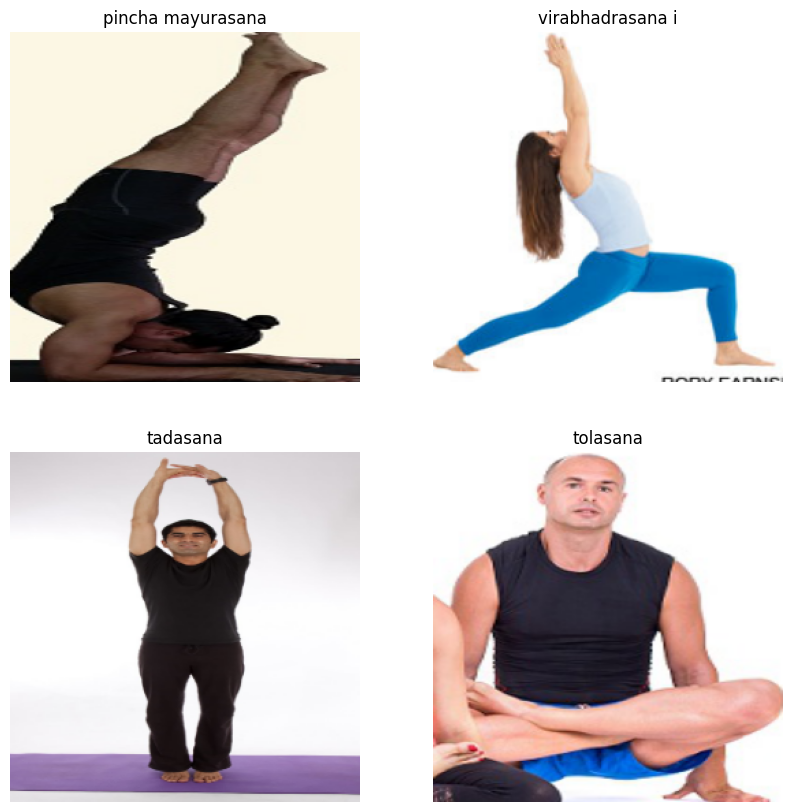

In [ ]:
# Print sample images from the training dataset:
class_names = train.class_names

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")


## Build Baseline and Advanced CNN Models from Scratch:

In [ ]:
model_1 = Sequential([
    Conv2D(128, (3, 3), padding = 'same', input_shape=(256, 256, 3), activation='relu', kernel_initializer='glorot_uniform'),
    #BatchNormalization()
    Conv2D(128, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), padding = 'same', activation='relu'),
    #BatchNormalization()
    Conv2D(128, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(107, activation='softmax')
])

# Compile the model:
precision = Precision()
recall = Recall()
opt = keras.optimizers.SGD(learning_rate=0.1, momentum = 0, nesterov = False, clipnorm=1.0)
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

In [ ]:
model_1_hist = model_1.fit(
  train,
  epochs=10,
  validation_data=val,
  verbose=1,
  callbacks=[
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    #ModelCheckpoint(filepath="model_1_best.h5", monitor="val_loss", save_best_only=True, verbose=1),
    tensorboard_callback,
    TqdmCallback(verbose=1)
    ])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
  5/260 [..............................] - ETA: 10s - loss: 13.9049 - accuracy: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

260/260 [==============================] - 15s 50ms/step - loss: 5.8230 - accuracy: 0.0123 - precision_1: 0.0063 - recall_1: 2.4102e-04 - val_loss: 7.1393 - val_accuracy: 0.0086 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.1000
Epoch 2/10
260/260 [==============================] - 13s 49ms/step - loss: 4.9557 - accuracy: 0.0135 - precision_1: 0.0213 - recall_1: 2.4102e-04 - val_loss: 4.6194 - val_accuracy: 0.0268 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 0.1000
Epoch 3/10
260/260 [==============================] - 13s 49ms/step - loss: 4.5549 - accuracy: 0.0566 - precision_1: 0.3465 - recall_1: 0.0084 - val_loss: 4.5590 - val_accuracy: 0.0380 - val_precision_1: 0.1667 - val_recall_1: 8.6430e-04 - lr: 0.1000
Epoch 4/10
260/260 [==============================] - 13s 49ms/step - loss: 3.5219 - accuracy: 0.2172 - precision_1: 0.6574 - recall_1: 0.0971 - val_loss: 4.8440 - val_accuracy: 0.0804 - val_precision_1: 0.2125 - val_recall_1: 0.0147 - lr: 0.

In [ ]:
model_1.save('model_1.keras')

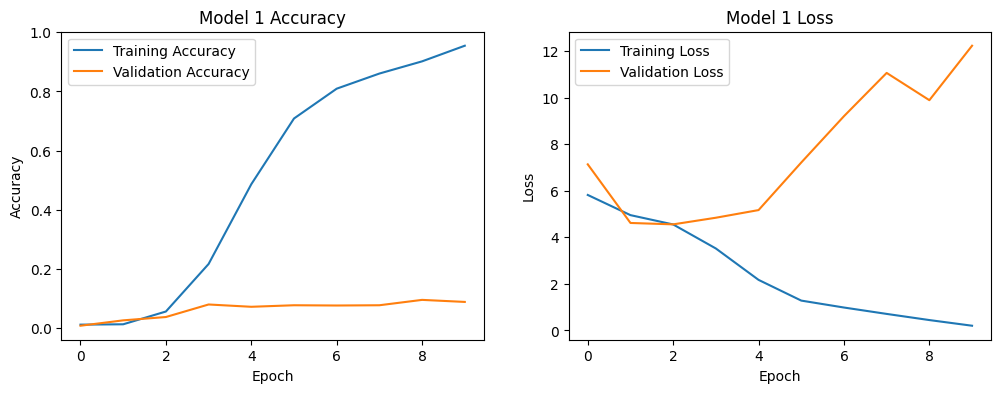

In [ ]:
# Create Accuracy and Loss Plots:

# Create a figure to display accuracy and loss plots
plt.figure(figsize=(12, 4))

# Plot the accuracy for training and validation
plt.subplot(1, 2, 1)
plt.plot(model_1_hist.history['accuracy'], label='Training Accuracy')
plt.plot(model_1_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy')
plt.legend()

# Plot the loss for training and validation
plt.subplot(1, 2, 2)
plt.plot(model_1_hist.history['loss'], label='Training Loss')
plt.plot(model_1_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# F1 Score and Confusion Matrix for model_1:

# Access metrics from the history object
precision = model_1_hist.history['precision']
recall = model_1_hist.history['recall']

# Calculate F1 score for each epoch
f1_score = [2 * (p * r) / (p + r) for p, r in zip(precision, recall)]

# Extract true labels from the validation dataset
y_true = np.concatenate([y for x, y in val], axis=0) # Extract labels from the dataset

# Generate confusion matrix
y_pred = np.argmax(model_1.predict(val), axis=1)
y_true = np.argmax(y_true, axis=1)
confusion_matrix_1 = confusion_matrix(y_true, y_pred)

confusion_matrix_display_1 = ConfusionMatrixDisplay(confusion_matrix_1)

# Print F1 scores for each epoch and the average F1 score
print("F1 Scores for each epoch:", f1_score)
print("Average F1 Score:", np.mean(f1_score))
print("Confusion Matrix:\n", confusion_matrix_1)

73/73 [==============================] - 4s 60ms/step
F1 Scores for each epoch: [0.0009372071176560433, 0.0009548818268065659, 0.10958903822951414, 0.5062132132948277, 0.7721945057647436, 0.8595755710754273, 0.9097632931105231, 0.9234561831578174, 0.9716157360382341, 0.9790936767075353]
Average F1 Score: 0.6033393306323085
Confusion Matrix:
 [[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


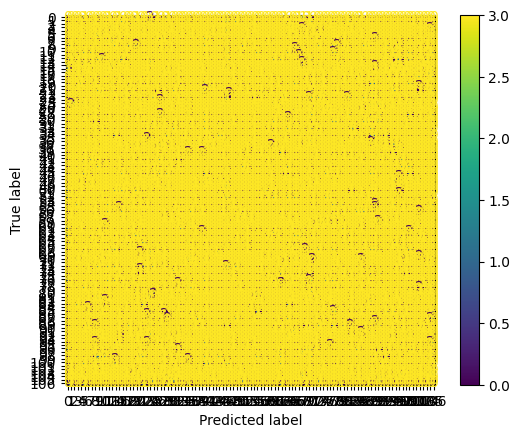

In [ ]:
confusion_matrix_display_1.plot()
plt.show()

In [ ]:
model_3 = Sequential([
    Conv2D(128, (3, 3), padding = 'same', input_shape=(256, 256, 3), activation='relu', kernel_initializer='glorot_uniform'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    BatchNormalization(),
    Conv2D(256, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(107, activation='softmax')
])

# Compile the model:
opt = keras.optimizers.SGD(learning_rate=0.1, momentum = 0, nesterov = False, clipnorm=1.0)
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

In [ ]:
model_3_hist = model_3.fit(
  train,
  epochs=20,
  validation_data=val,
  verbose=1,
  callbacks=[
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1),
    #ModelCheckpoint(filepath="model_3_best.h5", monitor="val_loss", save_best_only=True, verbose=1),
    tensorboard_callback,
    TqdmCallback(verbose=1)
  ]
  )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
  6/260 [..............................] - ETA: 19s - loss: 5.4039 - accuracy: 0.0208 - precision: 0.0000e+00 - recall: 0.0000e+00

260/260 [==============================] - 95s 134ms/step - loss: 4.7340 - accuracy: 0.0186 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.5520 - val_accuracy: 0.0259 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 2/20
260/260 [==============================] - 22s 86ms/step - loss: 4.2555 - accuracy: 0.0571 - precision: 0.4231 - recall: 0.0027 - val_loss: 4.0754 - val_accuracy: 0.0916 - val_precision: 1.0000 - val_recall: 8.6430e-04 - lr: 0.1000
Epoch 3/20
260/260 [==============================] - 22s 86ms/step - loss: 3.7445 - accuracy: 0.1253 - precision: 0.4720 - recall: 0.0183 - val_loss: 3.6704 - val_accuracy: 0.1694 - val_precision: 0.6324 - val_recall: 0.0372 - lr: 0.1000
Epoch 4/20
260/260 [==============================] - 23s 86ms/step - loss: 3.3372 - accuracy: 0.2051 - precision: 0.5531 - recall: 0.0540 - val_loss: 3.3901 - val_accuracy: 0.2066 - val_precision: 0.7805 - val_recall: 0.0277 - lr: 0.1000
Epoch 5/20
260/260 [==============

In [ ]:
# Save Model:
model_3.save('model_3.keras')

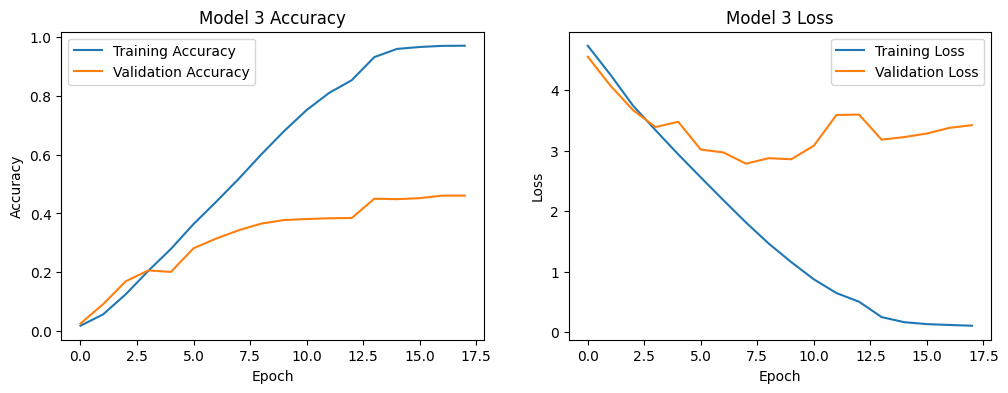

In [ ]:
# Create Accuracy and Loss Plots

# Create a figure to display accuracy and loss plots
plt.figure(figsize=(12, 4))

# Plot the accuracy for training and validation
plt.subplot(1, 2, 1)
plt.plot(model_3_hist.history['accuracy'], label='Training Accuracy')
plt.plot(model_3_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy')
plt.legend()

# Plot the loss for training and validation
plt.subplot(1, 2, 2)
plt.plot(model_3_hist.history['loss'], label='Training Loss')
plt.plot(model_3_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss')
plt.legend()

# Show the plot
plt.show()

73/73 [==============================] - 2s 23ms/step
F1 Scores for each epoch: [0, 0.005269461299771191, 0.035266822922034216, 0.09837505163056827, 0.19463916961522396, 0.29377024152774395, 0.39568981844345325, 0.4864058197436562, 0.5810246177368736, 0.6659877838248176, 0.7389312901931375, 0.807109933688543, 0.8528773962007674, 0.930761614045538, 0.9557977124744059, 0.9627011321059117, 0.9675695360758616, 0.9704917966886275]
Average F1 Score: 0.5523705110120519
Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


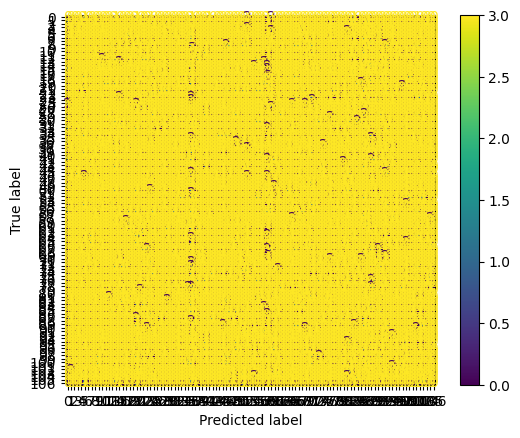

In [ ]:
# F1 Score and Confusion Matrix for model_3:

# Access metrics from the history object
precision = model_3_hist.history['precision']
recall = model_3_hist.history['recall']

# Calculate F1 score for each epoch
f1_score_3 = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(precision, recall)]

# Extract true labels from the validation dataset
y_true = np.concatenate([y for x, y in val], axis=0) # Extract labels from the dataset

# Generate confusion matrix
y_pred = np.argmax(model_3.predict(val), axis=1)
y_true = np.argmax(y_true, axis=1)
confusion_matrix_3 = confusion_matrix(y_true, y_pred)

confusion_matrix_display_3 = ConfusionMatrixDisplay(confusion_matrix_3)

# Print F1 scores for each epoch and the average F1 score
print("F1 Scores for each epoch:", f1_score_3)
print("Average F1 Score:", np.mean(f1_score_3))
print("Confusion Matrix:\n", confusion_matrix_3)

confusion_matrix_display_3.plot()
plt.show()

## Final Evaluation/Comparison of Models with Test Data:

In [ ]:
# Load first and third model (the baseline model and the model with highest validation accuracy):
model_1_loaded = keras.models.load_model('model_1.keras')
model_3_loaded = keras.models.load_model('model_3.keras')

In [ ]:
# Evaluate models on test set
model_1_eval = model_1_loaded.evaluate(test, verbose=1)
model_3_eval = model_3_loaded.evaluate(test, verbose=1)

43/43 [==============================] - 5s 64ms/step - loss: 2.6981 - accuracy: 0.3639 - precision: 0.6286 - recall: 0.2242


In [ ]:
# Get predictions
y_pred_1 = np.argmax(model_1_loaded.predict(test), axis=1)
y_pred_3 = np.argmax(model_3_loaded.predict(test), axis=1)

y_true = np.concatenate([y for x, y in test], axis=0)
y_true = np.argmax(y_true, axis=1)

43/43 [==============================] - 1s 28ms/step


In [ ]:
# Generate List of Class Names:
train_dir = "/content/107 yoga poses/train"  # Replace with your actual train directory path
class_names = sorted(os.listdir(train_dir))

In [ ]:
# For each model, identify the 5 classes with the highest/lowest accuracy on the test set:

# Calculate accuracy for each class
class_accuracy_1 = []
class_accuracy_3 = []

for class_idx in range(107):
  # Create a mask for the current class
  class_mask = y_true == class_idx

  # Get true and predicted labels for the current class
  y_true_class = y_true[class_mask]
  y_pred_class_1 = y_pred_1[class_mask]
  y_pred_class_3 = y_pred_3[class_mask]

  # Calculate accuracy for the current class
  if len(y_true_class) > 0:
    accuracy_1 = np.sum(y_true_class == y_pred_class_1) / len(y_true_class)
    accuracy_3 = np.sum(y_true_class == y_pred_class_3) / len(y_true_class)
  else:
    accuracy_1 = 0.0
    accuracy_3 = 0.0

  # Count observations of the class in the training set
  train_count = np.sum(np.argmax(np.concatenate([y for x, y in train], axis=0), axis=1) == class_idx)

  class_accuracy_1.append((class_idx, accuracy_1, train_count, class_names[class_idx]))
  class_accuracy_3.append((class_idx, accuracy_3, train_count, class_names[class_idx]))

# Sort classes by accuracy
class_accuracy_1.sort(key=lambda x: x[1], reverse=True)
class_accuracy_3.sort(key=lambda x: x[1], reverse=True)

# Print results
print("Model 1:")
print("Top 5 Classes:")
for i in range(5):
  print(f"Class {class_accuracy_1[i][0]} ({class_accuracy_1[i][3]}): {class_accuracy_1[i][1]*100:.2f}%, Train Count: {class_accuracy_1[i][2]}")

print("\nBottom 5 Classes:")
for i in range(1, 6):
  print(f"Class {class_accuracy_1[-i][0]} ({class_accuracy_1[-i][3]}): {class_accuracy_1[-i][1]*100:.2f}%, Train Count: {class_accuracy_1[-i][2]}")

print("\nModel 3:")
print("Top 5 Classes:")
for i in range(5):
  print(f"Class {class_accuracy_3[i][0]} ({class_accuracy_3[i][3]}): {class_accuracy_3[i][1]*100:.2f}%, Train Count: {class_accuracy_3[i][2]}")

print("\nBottom 5 Classes:")
for i in range(1, 6):
  print(f"Class {class_accuracy_3[-i][0]} ({class_accuracy_3[-i][3]}): {class_accuracy_3[-i][1]*100:.2f}%, Train Count: {class_accuracy_3[-i][2]}")


Model 1:
Top 5 Classes:
Class 83 (tulasana): 25.00%, Train Count: 21
Class 86 (urdhva hastasana): 16.67%, Train Count: 32
Class 1 (adho mukha vriksasana): 14.29%, Train Count: 41
Class 67 (purvottanasana): 14.29%, Train Count: 44
Class 72 (savasana): 14.29%, Train Count: 39

Bottom 5 Classes:
Class 106 (yoganidrasana): 0.00%, Train Count: 32
Class 105 (vrischikasana): 0.00%, Train Count: 35
Class 104 (vriksasana): 0.00%, Train Count: 43
Class 103 (virasana): 0.00%, Train Count: 35
Class 102 (virabhadrasana iii): 0.00%, Train Count: 42

Model 3:
Top 5 Classes:
Class 91 (uttana shishosana): 20.00%, Train Count: 35
Class 71 (salamba sirsasana): 16.67%, Train Count: 42
Class 100 (virabhadrasana i): 16.67%, Train Count: 38
Class 1 (adho mukha vriksasana): 14.29%, Train Count: 41
Class 104 (vriksasana): 14.29%, Train Count: 43

Bottom 5 Classes:
Class 106 (yoganidrasana): 0.00%, Train Count: 32
Class 105 (vrischikasana): 0.00%, Train Count: 35
Class 103 (virasana): 0.00%, Train Count: 35
Cla

Both of these models performed more or less as expected on the test data based on their results on the validation set (the base model had nearly identical performance of ~9% accuracy, while the accuracy of the more complex model dropped from ~46% to ~36%).

Both models seem to have struggled with similar poses, though it was surprising to see that those poses were not those with the fewest examples in the training set. Similarly, it was suprising that the classes with the largest number of observations in the training set were not the ones that either model did the best job of predicting. Based on this (as well as my fairly limited knowledge of yoga), it would seem that extreme similarities between poses is likely a larger issue with this dataset than class imbalance.

One particularly striking part of these results is that there seem to be several classes that both models are completely unable to identify (accuracy of 0%).